In [8]:
'''Validation the per-locus ABC method'''

%pylab inline
import sys
sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from LRT_functions import *
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import pyplot as plt
from scipy import stats
import time
PLOTDIR = '/storage/BonnieH/selection_project/validation_per_locus/figures/all_pers/'

Populating the interactive namespace from numpy and matplotlib


In [9]:
# Function to plot validation figures
def plot_figure(fig_num, opt_allele_list, est_s_dic, errors, s_vals, use_het, use_common, use_bins, num_bins, eps_bins, model, graph_type):
    
    plt.figure(fig_num)
    for opt_allele in opt_allele_list:
        per = 2
        if opt_allele == 6 or opt_allele == 12:
            per = 3
        if opt_allele == 7 or opt_allele == 10:
            per = 4
        if len(opt_allele_list) == 1:
            plt.errorbar(s_vals, est_s_dic[opt_allele], marker = 'o', label = str(opt_allele), yerr = errors[opt_allele])
            
        else:
            plt.errorbar(s_vals, est_s_dic[opt_allele], marker = 'o', label = 'Period: %d Opt allele: %d'%(per, opt_allele))
    
    if graph_type == 'abc':
        plt.plot( [10**-6,0.2],[10**-6,0.2] )
        plt.ylabel("Posterior estimation of s", size=15) 
        titlename = 'ABC Validation' 
        filename = PLOTDIR + 'ABC' 
        plt.yscale('log')
        
    if graph_type == 'lrt':
        plt.ylabel("Power", size=15) # -$log_{10}$(P value)
        titlename = 'LRT Validation'
        filename = PLOTDIR + 'LRT' 
    
    plt.xlabel("S value used for simulation", size=15)
    plt.xscale('log')
    plt.xlim(10**-6.5,0.3)
    plt.legend()
   
    opt_allele_string = '_'
    for opt_allele in opt_allele_list:
        opt_allele_string = opt_allele_string + str(opt_allele)
    filename = filename + opt_allele_string
    titlename = titlename + '\nSummary statistics used: '
    if use_het == 'y':
        filename = filename + '_het'
        titlename = titlename + 'Heterozygosity '
    if use_common == 'y':
        filename = filename + '_common'
        titlename = titlename + 'Number_Common_Alleles '
    if use_bins == 'y':
        filename = filename + '_' + str(num_bins) + 'bins' + '_' + str(eps_bins) 
        titlename = titlename + str(num_bins) + '_Allele_Bins '
    
    filename = filename + '_' + model[-2:]+ '.pdf'
    titlename = titlename + '\nPrior number ' + model[-1:]
    plt.title(titlename, size=15)
    plt.savefig(filename, bbox_inches='tight')
    print('Done figure ' + str(fig_num))

In [10]:
# Function to validate ABC and LRT
def validate(s_vals, use_het, use_common, use_bins, num_bins, model, fig_num):
    
    per_list = '2,3,4' # List of periods to validate
    per_list = list(per_list.split(','))
    per_list = list(map(int, per_list))
    opt_alleles = {} # Key: period, Value: list of optimal alleles to validate
    opt_alleles[2] = '11,20'
    opt_alleles[3] = '6,12'
    #opt_alleles[3] = '5,6,7,8,9,10,11,12'
    opt_alleles[4] = '7,10'
    
    opt_allele_list = [11,20,6,12,7,10]
    
    # Process list of s values
    s_vals = list(s_vals.split(','))
    s_vals = list(map(float, s_vals))
    
    # ABC parameters
    constant_het = 0.005
    denom_het = 3
    constant_common = 1
    denom_common = 4
    eps_bins = 0.3
    
    # LRT parameters
    LRT_num_sims = 200
         
    # Each dictionary contains values for all optimal alleles
    # Key: optimal allele
    # Value: list of mean values for each s 
    s_vals_dic = {}
    errors_s_dic = {}
    p_vals_dic = {}
    errors_p_dic = {}
    
    # Initialize dictionaries above
    for opt_allele in opt_allele_list:
        s_vals_dic[opt_allele] = []
        errors_s_dic[opt_allele] = []
        p_vals_dic[opt_allele] = []
        errors_p_dic[opt_allele] = []
      
    # Run ABC and LRT for each opt_allele
    for opt_allele in opt_allele_list:
        per = 2
        if opt_allele == 6 or opt_allele == 12:
            per = 3
        if opt_allele == 7 or opt_allele == 10:
            per = 4
        print('Running per: ' + str(per) + ' optimal allele: ' + str(opt_allele))
        no_ABC_accept = 0 # Number of s values with <10 ABC acceptances
        
        ### Get list of s values in LRT simulations file ###
        s_list_available = []
        lrtFile = '/gymreklab-tscc/bonnieh/lrt/results/' + 'euro_prelim' + '/' + str(per) + '_' + str(opt_allele) + '_freqs.txt'
        lrt_file = open(lrtFile, 'r')
        header = lrt_file.readline().strip()
    
        for line in lrt_file:
            info = line.strip().split('\t')
            s = float(info[0])
            if s not in s_list_available:
                s_list_available.append(s)
            
        est_s_dic = {} # Dictionary of estimated s values; Key: True value of s, Value: list of estimated s values
        
        # Put summary statistics in dictionaries
        obs_het_dic = {} # Key - s; value - list of het
        obs_comm_dic = {} # Key - s; value - list of number of common alleles (frequency >= 5%)
        obs_bins_dic = {} # Key - s; value - list of bins (bins are given as lists)
        
        # Same as dictionaries above except without simulations 
        # where s could not be estimated using ABC (<10 ABC acceptances)
        # These are the simulations used for LRT
        obs_het_dic_lrt = {}
        obs_comm_dic_lrt = {}
        obs_bins_dic_lrt = {}
    
        # Fill in dictionaries of summary statistics
        for s in s_vals:
            
            obs_het_dic[s] = []
            obs_comm_dic[s] = []
            obs_bins_dic[s] = []
            
            freqs_list_raw = GetLRTListFreq(lrtFile, s) # Get list of allele frequencies for this s
            
            # Get summary statistics from frequencies
            for freq_string in freqs_list_raw:
                
                obs_het, obs_common, obs_bins = GetSummStats(freq_string, num_bins)
                obs_het_dic[s].append(obs_het)
                obs_comm_dic[s].append(obs_common)
                obs_bins_dic[s].append(obs_bins)
            
        abcFile = '/gymreklab-tscc/bonnieh/abc/results/' + model +'/' + str(per) + '_' + str(opt_allele) + '.txt' 

        # Read abcFile line by line and place in lookup table in the form of a list
        abc_list = GetABCList(abcFile, num_bins)
        
        # Perform ABC
        for s in s_vals:
            
            list_est_s = [] # List of posterior estimates of s
            # Lists of summary statistics of s
            list_het = []
            list_common = []
            list_bins = []
            
            for i in range(0, len(obs_het_dic[s])):
                obs_het  = float(obs_het_dic[s][i])
                obs_common = int(obs_comm_dic[s][i])
                obs_bins = obs_bins_dic[s][i]
                
                s_ABC, lower_bound, upper_bound, num_accepted, s_accepted = Get_S_ABC(abc_list, \
                                       obs_het, obs_common, obs_bins, constant_het, \
                                       denom_het, constant_common, denom_common, eps_bins, use_het, \
                                       use_common, use_bins)
                if s_ABC != -1:
        
                    s_ABC_round = get_LRT_bin(s_ABC)
            
                    # Get nearest s in LRT file to perform LRT
                    if s_ABC_round not in s_list_available:
                        #print('Not available: per %d opt allele %d s_ABC_round %.5f'%(per, opt_allele, s_ABC_round))
                        s_ABC_round = getNearestS(s_ABC_round, s_list_available)
                        #print('Nearest s: %.5f'%(s_ABC_round))
                    list_est_s.append(s_ABC_round) 
                    list_het.append(obs_het)
                    list_common.append(obs_common)
                    list_bins.append(obs_bins)
                else:
                    no_ABC_accept = no_ABC_accept + 1
                    
            est_s_dic[s] = list_est_s
            obs_het_dic_lrt[s] = list_het
            obs_comm_dic_lrt[s] = list_common
            obs_bins_dic_lrt[s] = list_bins
            #print(s)
            #print(list_est_s)
            
            # Put mean of esimated s in s_vals_dic and calculate standard error of the mean
            s_vals_dic[opt_allele].append(np.mean(list_est_s)) 
            std_err = stats.sem(list_est_s, ddof=0)
            errors_s_dic[opt_allele].append(std_err)
            
        # Get LRT summary statistic tables for s = 0
        freqs_list_raw_0 = GetLRTListFreq(lrtFile, 0)
        LRT_table_0_het = []
        LRT_table_0_common = []
        LRT_table_0_bins = []
        
        # Get summary statistics from allele frequencies
        for freq_string in freqs_list_raw_0:
                
            obs_het, obs_common, obs_bins = GetSummStats(freq_string, num_bins)
            LRT_table_0_het.append(obs_het) 
            LRT_table_0_common.append(obs_common) 
            LRT_table_0_bins.append(obs_bins)
                
        # Perform LRT
        for s in est_s_dic:
            p_vals_list = []
            obs_het_list = obs_het_dic_lrt[s]
            obs_common_list = obs_comm_dic_lrt[s]
            obs_bins_list = obs_bins_dic_lrt[s]
            s_ABC_list = est_s_dic[s]
            
            for i in range(0, len(obs_het_list)):
                obs_het = obs_het_list[i]
                obs_common = obs_common_list[i]
                obs_bins = obs_bins_list[i]
                s_ABC_round = s_ABC_list[i]
                
                ### Use commented code if didn't round during ABC ###
                '''
                s_ABC_round = get_LRT_bin(s_ABC_round)
                if s_ABC_round not in s_list_available:
                    s_ABC_round = getNearestS(s_ABC_round, s_list_available)
                '''
                
                # Get LRT summary statistic tables for s = s_ABC_round
                freqs_list_raw_s = GetLRTListFreq(lrtFile, s_ABC_round)
            
                LRT_table_s_het = []
                LRT_table_s_common = []
                LRT_table_s_bins = []
                
                # Get summary statistics from allele frequencies
                for freq_string in freqs_list_raw_s:
                    
                    obs_het, obs_common, obs_bins = GetSummStats(freq_string, num_bins)
                    LRT_table_s_het.append(obs_het) 
                    LRT_table_s_common.append(obs_common) 
                    LRT_table_s_bins.append(obs_bins)
                
                if len(LRT_table_s_het) != 0:
                    likelihood_0, likelihood_s_ABC, LR, LogLR, pval = LikelihoodRatioTest(LRT_table_0_het, LRT_table_s_het, \
                                LRT_table_0_common, LRT_table_s_common, LRT_table_0_bins, LRT_table_s_bins, LRT_num_sims, \
                                obs_het, obs_common, obs_bins, constant_het, denom_het, \
                                constant_common, denom_common, eps_bins, use_het, use_common, use_bins)
                
                    p_vals_list.append(pval) # -1*np.log10(pval)
                
            # Put mean of esimated p in p_vals_dic and calculate standard error of the mean
            #print(s)
            #print(p_vals_list)
            p_vals_dic[opt_allele].append(len([i for i in p_vals_list if i < 0.05])/len(p_vals_list)*100) # np.mean(p_vals_list)
            std_err = stats.sem(p_vals_list, ddof = 0)
            errors_p_dic[opt_allele].append(std_err)
            
            #print(no_ABC_accept)
          
    # Plot ABC and LRT validation graphs
    fig_num = fig_num + 1
    plot_figure(fig_num, opt_allele_list, s_vals_dic, errors_s_dic, s_vals, use_het, use_common, use_bins, num_bins, eps_bins, model, 'abc')
    fig_num = fig_num + 1
    plot_figure(fig_num, opt_allele_list, p_vals_dic, errors_p_dic, s_vals, use_het, use_common, use_bins, num_bins, eps_bins, model, 'lrt')
    return fig_num

In [11]:
def main():
    print('Running main')
    
    
    
    s_vals = '0.000001,0.00001,0.0001,0.001,0.004,0.007,0.01,0.04,0.07,0.1,0.15,0.2' # S values to validate
    #s_vals = '0.000001,0.0001,0.01'
   
    # Summary statistics to use
    use_het = 'y'
    use_common = 'n'
    use_bin = 'y'
    
    #num_bins_list = [3,5,7] # Number of bins to use for validation
    num_bins = 5
    
    #model_list = ['euro_p1', 'euro_p2']
    model = 'euro_p2' # Prior to use
    fig_num = 0
    
    # Run validation
    
    
    fig_num = validate(s_vals, use_het, use_common, use_bin, num_bins, model, fig_num)

Running main
Running per: 2 optimal allele: 11
Running per: 2 optimal allele: 20
Running per: 3 optimal allele: 6
Running per: 3 optimal allele: 12
Running per: 4 optimal allele: 7
Running per: 4 optimal allele: 10
Done figure 1
Done figure 2
CPU times: user 7min 35s, sys: 4.09 s, total: 7min 39s
Wall time: 12min 49s


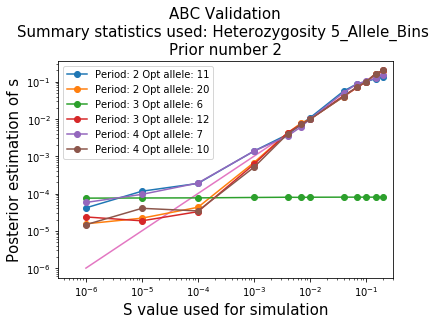

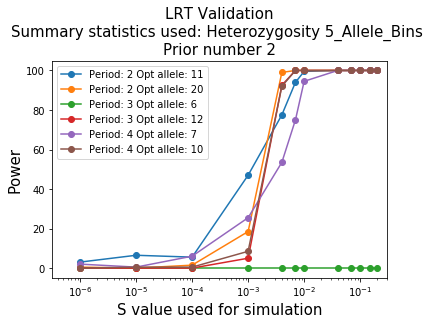

In [12]:
%%time
if __name__ == '__main__':
    main()